In [1]:
import os
import glob
import cv2
import time
import copy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # stateless functions
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import cohen_kappa_score,confusion_matrix

In [2]:
class CFG:
    batch_size = 16
    debug = False
    device = torch.device('cuda')
    dtype = torch.float32
    epochs = 30
    nfolds = 4
    seed = 524
    TRAIN = '../yi_data/panda-16x128x128-tiles-data/train/'
    LABELS = '../data/train.csv'

# Split Data

In [3]:
train = pd.read_csv(CFG.LABELS).set_index('image_id')
files = sorted(set([p[:32] for p in os.listdir(CFG.TRAIN)]))
train = train.loc[files].reset_index()

if CFG.debug:
    df = train.sample(n=200, random_state=CFG.seed).copy()
else:
    df = train.copy()

# Generate train/validation sets containing the same distribution of isup_grade
splits = StratifiedKFold(n_splits=CFG.nfolds, random_state=CFG.seed, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
# Assign split index to training samples
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(CFG.nfolds):
    folds_splits[splits[i][1]] = i
df['split'] = folds_splits
df.head()

,image_id,data_provider,isup_grade,gleason_score,split
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,2
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,3
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,0


In [4]:
# https://www.kaggle.com/yasufuminakama/panda-se-resnext50-regression-baseline
class TrainDataset(Dataset):
    """Prostate Cancer Biopsy Dataset"""
    
    def __init__(self, df, labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            root_dir (string): Path to the directory with all images
            transform (callable, optional): Optional transform to be applied on an image sample
        """
        # Shuffle dataframes with fixed seed; otherwise, validation set only get cancerous samples
        self.df = df
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # https://stackoverflow.com/questions/33369832/read-multiple-images-on-a-folder-in-opencv-python
        img_fns = [fn for fn in glob.glob(f"{CFG.TRAIN}/{self.df['image_id'][idx]}_*.png")]
        imgs = [cv2.imread(fn) for fn in img_fns]
        # (D,W,H)
        img = cv2.hconcat([cv2.vconcat([imgs[0], imgs[1], imgs[2], imgs[3]]),
                           cv2.vconcat([imgs[4], imgs[5], imgs[6], imgs[7]]),
                           cv2.vconcat([imgs[8], imgs[9], imgs[10], imgs[11]]),
                           cv2.vconcat([imgs[12], imgs[13], imgs[14], imgs[15]])])
        
        if self.transform:
            img = self.transform(img)
            
        label = torch.tensor(self.labels[idx])
        return img, label

## Transforms

In [5]:
def get_transforms(phase):
    assert phase in {'train', 'val'}
    
    if phase == 'train':
        return T.Compose([
            T.ToTensor(),
            T.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                #mean=[0.8776, 0.8186, 0.9090],
                #std=[0.1659, 0.2507, 0.1357],
            ),
            # TODO: Add normalize
        ])
    else:
        return T.Compose([
            T.ToTensor(),
            T.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                #mean=[0.8776, 0.8186, 0.9090],
                #std=[0.1659, 0.2507, 0.1357],
            ),
        ])

In [6]:
# Use fold idx as validation set
def data_loader(fold_idx):
    train_idx = df[df['split'] != fold_idx].index
    val_idx = df[df['split'] == fold_idx].index

    train_dataset = TrainDataset(df.loc[train_idx].reset_index(drop=True),
                                 df.loc[train_idx].reset_index(drop=True)['isup_grade'],
                                 transform = get_transforms(phase='train'))
    val_dataset = TrainDataset(df.loc[val_idx].reset_index(drop=True),
                               df.loc[val_idx].reset_index(drop=True)['isup_grade'],
                               transform = get_transforms(phase='train'))
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader

In [7]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    # Send the model to GPU/CPU
    model = model.to(device=CFG.device)
    
    train_acc_history = []
    val_acc_history = []
    loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    preds, targets = [], []
    
    for epoch in range(num_epochs):
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set model to training phase
            else:
                model.eval()    # Set model to evaluate phase
            
            avg_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloaders[phase],
                                       desc='{}/{}({:5s})'.format(epoch+1,num_epochs,phase)):
                inputs = inputs.to(device=CFG.device, dtype=CFG.dtype)
                labels = labels.to(device=CFG.device, dtype=torch.long)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward, track history if only in training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    pred = torch.argmax(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                avg_loss += loss.item()*(inputs.size(0)/len(dataloaders[phase].dataset))  # len(dataloaders[phase].dataset) not len(dataloaders[phase])
                running_corrects += torch.sum(pred == labels)
                preds.append(pred)
                targets.append(labels)
            
            # End of epoch
            with torch.no_grad():
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                if phase == 'val':
                    val_acc_history.append(epoch_acc)
                    p = torch.cat(preds).cpu()
                    t = torch.cat(targets).cpu()
                    kappa = cohen_kappa_score(t, p, weights='quadratic')
                    #print(confusion_matrix(t,p)) https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
                    # deep copy the model
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                else:
                    train_acc_history.append(epoch_acc)
                    loss_history.append(avg_loss)
                print('{} Loss: {:4f} Acc: {:4f} Kaap: {:4f}'.format(
                          phase, avg_loss, epoch_acc, kappa if phase=='val' else 1))

                if scheduler is not None and phase == 'train':
                    scheduler.step()
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, loss_history, train_acc_history, val_acc_history

## AlexNet

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

def initialize_model(num_classes, feature_extract=False, use_pretrained=False):
    model_ft = None
    input_size = 0
    
    model_ft = models.alexnet(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    #input_size = 128
    
    return model_ft, input_size

In [9]:
model_ft, input_size = initialize_model(6)
#print(model_ft)

optimizer = optim.SGD(model_ft.parameters(),
                      lr=3e-3,
                      momentum=.9,
                      nesterov=True)

loader_train, loader_val = data_loader(0)()
best_model, loss_history, train_acc_history, val_acc_history = train_model(model_ft, {'train': loader_train, 'val': loader_val}, F.cross_entropy, optimizer, None, CFG.epochs)
print(loss_history)
print(train_acc_history)
print(val_acc_history)


train Loss: 1.689471 Acc: 0.260682 Kaap: 1.000000



val Loss: 1.651554 Acc: 0.270825 Kaap: 0.027224




train Loss: 1.649438 Acc: 0.276658 Kaap: 1.000000



val Loss: 1.643398 Acc: 0.248764 Kaap: 0.051294




train Loss: 1.633159 Acc: 0.282110 Kaap: 1.000000



val Loss: 1.625439 Acc: 0.284899 Kaap: 0.071004




train Loss: 1.622249 Acc: 0.294409 Kaap: 1.000000



val Loss: 1.601063 Acc: 0.294789 Kaap: 0.091495




train Loss: 1.606653 Acc: 0.309623 Kaap: 1.000000



val Loss: 1.616106 Acc: 0.310765 Kaap: 0.147699




train Loss: 1.601978 Acc: 0.316977 Kaap: 1.000000



val Loss: 1.603312 Acc: 0.311525 Kaap: 0.180663




train Loss: 1.590918 Acc: 0.323570 Kaap: 1.000000



val Loss: 1.577080 Acc: 0.314949 Kaap: 0.215254




train Loss: 1.583742 Acc: 0.325979 Kaap: 1.000000



val Loss: 1.572733 Acc: 0.320654 Kaap: 0.239272




train Loss: 1.581650 Acc: 0.335869 Kaap: 1.000000



val Loss: 1.579765 Acc: 0.327121 Kaap: 0.258320




train Loss: 1.573671 Acc: 0.338025 Kaap: 1.000000



val Loss: 1.571658 Acc: 0.330164 Kaap: 0.276303




train Loss: 1.572064 Acc: 0.342462 Kaap: 1.000000



val Loss: 1.569866 Acc: 0.315329 Kaap: 0.289667




train Loss: 1.554828 Acc: 0.352732 Kaap: 1.000000



val Loss: 1.567808 Acc: 0.337771 Kaap: 0.303943




train Loss: 1.553455 Acc: 0.354000 Kaap: 1.000000



val Loss: 1.560858 Acc: 0.356029 Kaap: 0.315002




train Loss: 1.544473 Acc: 0.360086 Kaap: 1.000000



val Loss: 1.566777 Acc: 0.341194 Kaap: 0.323786




train Loss: 1.531629 Acc: 0.365919 Kaap: 1.000000



val Loss: 1.557456 Acc: 0.366679 Kaap: 0.332500




train Loss: 1.521355 Acc: 0.364397 Kaap: 1.000000



val Loss: 1.575457 Acc: 0.322176 Kaap: 0.339582




train Loss: 1.508782 Acc: 0.374540 Kaap: 1.000000



val Loss: 1.535290 Acc: 0.362495 Kaap: 0.348494




train Loss: 1.498560 Acc: 0.377964 Kaap: 1.000000



val Loss: 1.612779 Acc: 0.349943 Kaap: 0.356549




train Loss: 1.490623 Acc: 0.387727 Kaap: 1.000000



val Loss: 1.488226 Acc: 0.395588 Kaap: 0.364320




train Loss: 1.479458 Acc: 0.391657 Kaap: 1.000000



val Loss: 1.492096 Acc: 0.397490 Kaap: 0.371080




train Loss: 1.465862 Acc: 0.400786 Kaap: 1.000000



val Loss: 1.478894 Acc: 0.391784 Kaap: 0.378316




train Loss: 1.451888 Acc: 0.403449 Kaap: 1.000000



val Loss: 1.568908 Acc: 0.370483 Kaap: 0.384949




train Loss: 1.444996 Acc: 0.411817 Kaap: 1.000000



val Loss: 1.472937 Acc: 0.401674 Kaap: 0.391689




train Loss: 1.435347 Acc: 0.412324 Kaap: 1.000000



val Loss: 1.471807 Acc: 0.400913 Kaap: 0.397578




train Loss: 1.431939 Acc: 0.416255 Kaap: 1.000000



val Loss: 1.470376 Acc: 0.394827 Kaap: 0.403549




train Loss: 1.413299 Acc: 0.423228 Kaap: 1.000000



val Loss: 1.492312 Acc: 0.401674 Kaap: 0.408834




train Loss: 1.404800 Acc: 0.435527 Kaap: 1.000000



val Loss: 1.489647 Acc: 0.403576 Kaap: 0.414785




train Loss: 1.392579 Acc: 0.437555 Kaap: 1.000000



val Loss: 1.486726 Acc: 0.389121 Kaap: 0.420427




train Loss: 1.382688 Acc: 0.439077 Kaap: 1.000000



val Loss: 1.465262 Acc: 0.399772 Kaap: 0.425659




train Loss: 1.362116 Acc: 0.446304 Kaap: 1.000000



val Loss: 1.488377 Acc: 0.386078 Kaap: 0.430801

Training complete in 1324m 6.374866s
Best val Acc: 0.403576
[1.6894708464048018, 1.6494383671384387, 1.6331593877872899, 1.622249245900564, 1.6066531996408384, 1.6019782574892931, 1.5909179589647717, 1.5837415044292893, 1.581650170035064, 1.5736711711745701, 1.5720637920798493, 1.5548280147873161, 1.5534552395593184, 1.5444726234941226, 1.531629367126807, 1.521354815904609, 1.5087817000151755, 1.4985602027157388, 1.490622816618454, 1.4794579497063223, 1.4658620983562471, 1.451887565676639, 1.4449956507922825, 1.4353465667556295, 1.4319386354368775, 1.4132991425661867, 1.4048002519670435, 1.3925792793515996, 1.382687727746302, 1.3621163612477927]
[tensor(0.2607, device='cuda:0', dtype=torch.float64), tensor(0.2767, device='cuda:0', dtype=torch.float64), tensor(0.2821, device='cuda:0', dtype=torch.float64), tensor(0.2944, device='cuda:0', dtype=torch.float64), tensor(0.3096, device='cuda:0', dtype=torch.float64), tensor(0.3170, device='cu

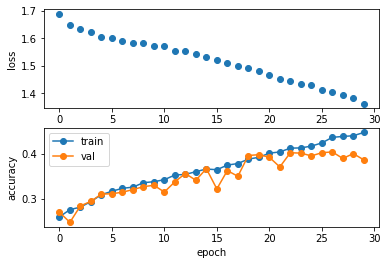

In [10]:
"""
Graphs
1. loss vs. iterations
2. Train/Validation accuracy along epoch
"""
plt.subplot(2,1,1)
plt.plot(loss_history, 'o')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()